In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision import transforms
import torchvision.transforms.functional as F
import json
import pandas as pd
import numpy as np
import os

# Armado del Dataset

In [3]:
def augment_csv(n_augment, img_labels):
    """Repeats each row of the DataFrame n_augment times."""

    if n_augment == 0:
        return img_labels

    # Repeat each row of the filtered DataFrame n_augment times
    repeated_df = img_labels.loc[img_labels.index.repeat(n_augment)]
    repeated_df = repeated_df.reset_index(drop=True)  # Restablecer el índice

    return repeated_df

In [4]:
from PIL import Image
import torchvision.transforms.functional as TF

#Estableciendo la estructura del dataset
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, n_augment=0,
                 split="train", transform=None, test_size=0.2, val_size=0.2, random_seed=42):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

        # Dividir aleatoriamente en entrenamiento y prueba
        np.random.seed(random_seed)
        indices = np.random.permutation(len(self.img_labels))
        split_index = int(len(self.img_labels) * (1 - test_size - val_size))
        val_split_index = int(len(self.img_labels) * (1 - val_size))

        if split == "train":
            self.img_labels = self.img_labels.iloc[indices[:split_index]]
        elif split == "test":
            self.img_labels = self.img_labels.iloc[indices[split_index:val_split_index]]
        else:
            self.img_labels = self.img_labels.iloc[indices[val_split_index:]]

        self.img_labels = augment_csv(n_augment,  self.img_labels)

        #Asegurar que no haya overlap
        train_indices = set(indices[:split_index])
        val_indices = set(indices[split_index:val_split_index])
        test_indices = set(indices[val_split_index:])
        assert len(train_indices & val_indices) == 0, "Overlap between train and val"
        assert len(train_indices & test_indices) == 0, "Overlap between train and test"
        assert len(val_indices & test_indices) == 0, "Overlap between val and test"

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
         img_filename = self.img_labels.iloc[idx]['filename']
         img_path = os.path.join(self.img_dir, img_filename)
         image = Image.open(img_path).convert('RGB')
         image = TF.to_tensor(image)

        # Lee los atributos de la bounding box
         shape_attributes = json.loads(self.img_labels.iloc[idx]['region_shape_attributes'])
         label = self.img_labels.iloc[idx]['region_attributes']

        # Extrae los extremos superior izq y el inferior der.
         x_1 = shape_attributes['x'] # Coordenada x del extremo superior izquierdo
         y_1 = shape_attributes['y']  # Coordenada y del extremo superior izquierdo
         x_2 =  shape_attributes['x'] + shape_attributes['width']
         y_2 = shape_attributes['y'] + shape_attributes['height']

         bbox = torch.tensor([x_1, y_1, x_2, y_2])
         bb_box = tv_tensors.BoundingBoxes(bbox.unsqueeze(0), format="XYXY", canvas_size=(image.shape[1], image.shape[2]))

        # Si hay transformaciones definidas, se aplican
         if self.transform:
            # Aplica transformaciones a imagen y bounding box
            image, bb_box = self.transform(image, bb_box)

         return image, bb_box, label


In [5]:
transform = v2.Compose([
    v2.Resize(size=(500,500)),#aplicamos resize para que torch.stack no tenga problemas ya que habian imagenes que no tenian el mismo tamaño
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    v2.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.9,1.1), shear=5),
    v2.RandomPerspective(distortion_scale=0.15, p=0.5)
])

resize = v2.Resize(size=(500,500))

train_dataset = ImageDataset(
    annotations_file= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras_Matias_Gonza.csv",
    img_dir= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras",
    n_augment = 25,
    split="train",
    transform=transform
)

test_dataset = ImageDataset(
    annotations_file= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras_Matias_Gonza.csv",
    img_dir= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras",
    n_augment = 25,
    split="test",
    transform=transform
)

val_dataset = ImageDataset(
    annotations_file= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras_Matias_Gonza.csv",
    img_dir= "/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras",
    n_augment = 25,
    split="val",
    transform=transform
)

In [6]:
print("Total: ", len(pd.read_csv("/content/drive/MyDrive/Proyecto-Integrador-Redes/Dataset/Letras_Matias_Gonza.csv")))
print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))
print("Tamaño del conjunto de validacion:", len(val_dataset))

Total:  236
Tamaño del conjunto de entrenamiento: 3525
Tamaño del conjunto de prueba: 1175
Tamaño del conjunto de validacion: 1200


In [7]:
#Generamos los dataloaders
from torch.utils.data import DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=16, # no usar batch mas grandes por que se supera la memoria de la GPU
    shuffle=True,
    num_workers=2
)
# DataLoader para el conjunto de prueba
test_loader = DataLoader(
    test_dataset,
    batch_size=16,# no usar batch mas grandes por que se supera la memoria de la GPU
    shuffle=False,
    num_workers=2
)
# DataLoader para el conjunto de validacion
val_loader = DataLoader(
    val_dataset,
    batch_size= 16,
    shuffle=False,
    num_workers=2
)

In [8]:
data_iter = iter(train_loader)
images, bboxes,label = next(data_iter)# mostramos que el dataset devuelve las label correctamente
print("Las etiquetas son: ", label)
print("Las imagenes son: ", images)
print("Las bounding boxes son: ", bboxes)

Las etiquetas son:  ('{"Label":"O"}', '{"Label":"N"}', '{"Label":"E"}', '{"Label":"B"}', '{"Label":"B"}', '{"Label":"E"}', '{"Label":"W"}', '{"Label":"V"}', '{"Label":"S"}', '{"Label":"V"}', '{"Label":"J"}', '{"Label":"G"}', '{"Label":"Y"}', '{"Label":"M"}', '{"Label":"Y"}', '{"Label":"C"}')
Las imagenes son:  tensor([[[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.8119, 0.8016, 0.7938,  ..., 0.0000, 0.0000, 0.0000],
          [0.8135, 0.8055, 0.7979,  ..., 0.0000, 0.0000, 0.0000],
          [0.8131, 0.7952, 0.7921,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.7628, 0.7525, 0.7446,  ..., 0.0000, 0.0000, 0.000

In [9]:
#Prueba de imagenes
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_image_with_bbox(img, bbox, title=""):
    img_np = img.permute(1, 2, 0).numpy()  # Convertir a numpy [H, W, C]
    fig, ax = plt.subplots(1)
    ax.imshow(img_np)

    # Convertir de extremos a coordenadas de esquina superior izquierda
    x_1, y_1, x_2, y_2 = bbox
    width = x_2 - x_1
    height = y_2 - y_1

    # Crear el rectángulo con las nuevas coordenadas
    rect = patches.Rectangle((x_1, y_1), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.title(title)
    plt.axis("off")
    plt.show()

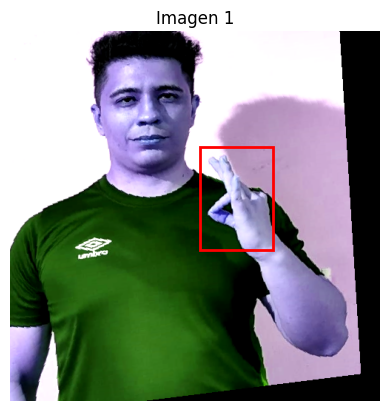

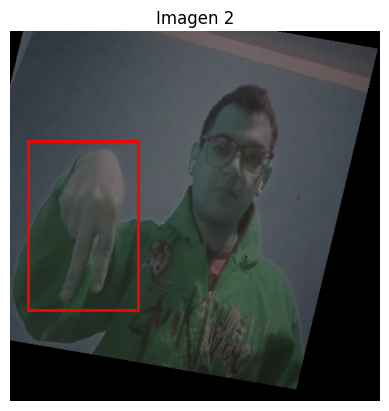

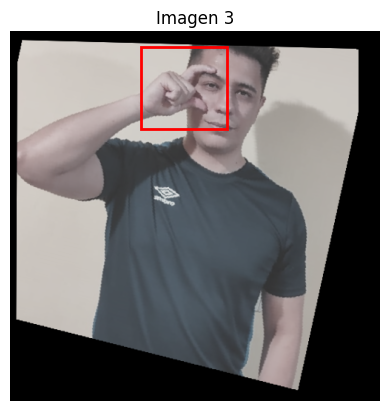

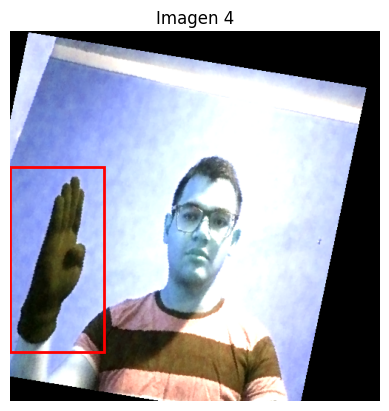

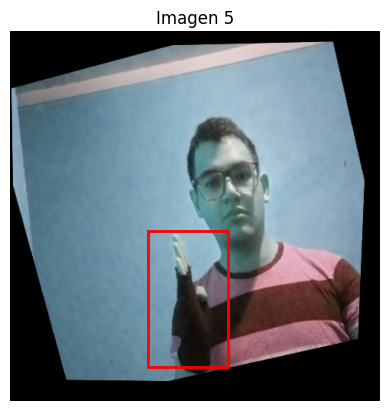

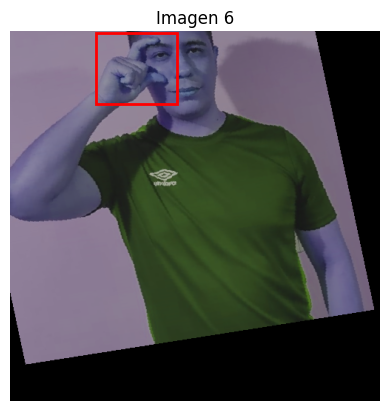

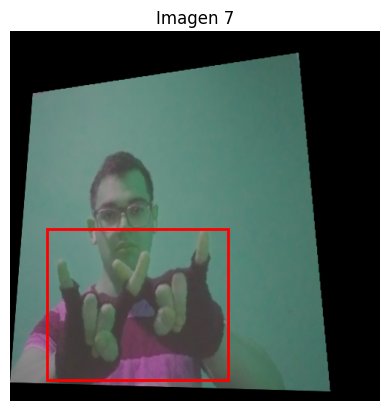

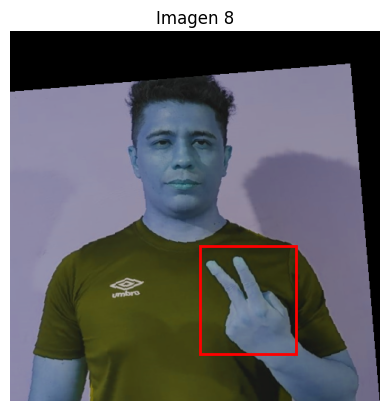

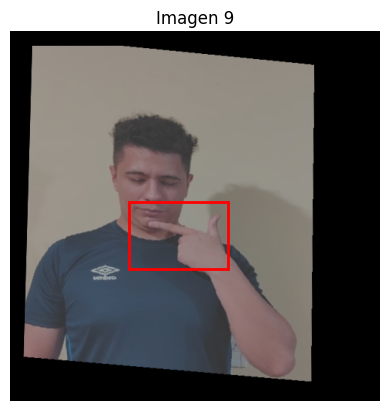

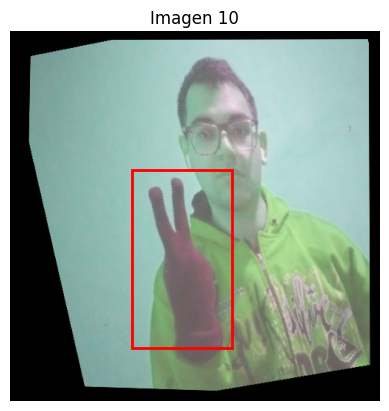

In [10]:
for i in range(10):
    img = images[i]
    bbox = bboxes[i].squeeze().tolist()  # Convertir bbox a una lista de Python

    # Llamar a la función plot_image_with_bbox
    plot_image_with_bbox(img, bbox, title=f"Imagen {i+1}")

# Implementación del módelo

In [11]:
import torch.nn as nn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
class CustomBoxPredictor(nn.Module):
    def __init__(self, in_features, num_classes):
        super(CustomBoxPredictor, self).__init__()
        self.cls_score = nn.Linear(in_features, num_classes)
        # Agregamos una capa para la regresión de las cajas
        self.bbox_pred = nn.Linear(in_features, num_classes * 4)

    def forward(self, x):
        # Retornamos los logits de las clases y las regresiones de las cajas
        return self.cls_score(x), self.bbox_pred(x)


In [13]:
#Configuración del modelo y estableciendo el numero de clases necesarias
model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
#print(model) Verificamos la estructura del modelo para ver como se debe aplicar el fine-tunning
num_classes = 27 #Letras + fondo
# Obtener in_features
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Reemplazar el predictor de cajas
model.roi_heads.box_predictor = CustomBoxPredictor(in_features, num_classes)

In [14]:
# Configura el dispositivo (CPU o GPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Configura el optimizador
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)

In [15]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            # Inicialización de Xavier para los pesos
            nn.init.xavier_uniform_(m.weight)
            # Inicializar el sesgo a cero
            if m.bias is not None:
                nn.init.zeros_(m.bias)

In [16]:
label_map = {
    "A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8, "I": 9,
    "J": 10, "K": 11, "L": 12, "M": 13, "N": 14, "O": 15, "P": 16, "Q": 17,
    "R": 18, "S": 19, "T": 20, "U": 21, "V": 22, "W": 23, "X": 24, "Y": 25,
    "Z": 26
}

In [17]:
# Invertir el diccionario label_map
inverse_label_map = {v: k for k, v in label_map.items()}

# Función para obtener la letra desde el número
def get_letter_from_number(number):
    return inverse_label_map.get(number, "Unknown")  # Retorna "Unknown" si el número no está en el mapa


In [18]:
def train(model, train_loader, optimizer, device, num_epochs,label_map, nuevo = False ):
    model.to(device)
    best_acc = float(0)
    metrics = []

#Carga las metricas anteriores, y busca la maxima accuracy
    metrics_file = '/content/drive/MyDrive/Proyecto-Integrador-Redes/metrics-rcnn.csv'

    if not nuevo and os.path.exists(metrics_file):
        metrics_df = pd.read_csv(metrics_file)
        metrics = metrics_df.to_dict(orient='records')
        if 'test_acc' in metrics_df.columns:
            best_acc = metrics_df['test_acc'].max()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        torch.cuda.empty_cache()

        for images, bboxes, labels in train_loader:
            # Mover los datos al dispositivo (GPU o CPU)
            images = [img.to(device) for img in images]
            bboxes = [bbox.to(device) for bbox in bboxes]
            numerical_labels = []
            for label_json in labels:
                # Convertir la cadena JSON a un diccionario
                label_dict = json.loads(label_json)
                # Extraer la letra de la etiqueta
                label_str = label_dict["Label"]

                # Obtener el valor numérico de la etiqueta
                if label_str in label_map:
                    numerical_labels.append(torch.tensor([label_map[label_str]]).to(device))
                else:
                    print(f"Advertencia: Etiqueta inválida '{label_str}' encontrada. Ignorando.")

            # Preparar las anotaciones para el modelo
            targets = []
            for bbox, numerical_label in zip(bboxes, numerical_labels):
                targets.append({"boxes": bbox, "labels": numerical_label})

            # Hacer la predicción y calcular la pérdida
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

            # Backpropagación
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        test_acc, _ = test_iou(model, test_loader, device, label_map)

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), '/content/drive/MyDrive/Proyecto-Integrador-Redes/best_rcnn.pt')
            print(f"Mejor modelo guardado con accuracy: {best_acc*100:.2f}%")

        #Guarda las metricas
        metrics.append({'train_loss': total_loss/len(train_loader), 'test_acc': test_acc})
        metrics_df = pd.DataFrame(metrics)
        metrics_df.to_csv('/content/drive/MyDrive/Proyecto-Integrador-Redes/metrics-rcnn.csv')

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}, Test Accuracy: {test_acc*100:.2f}%")

In [ ]:
from sklearn.metrics import accuracy_score
from torchvision.ops import box_iou

# Función de testeo
def test_iou(model, loader, device, label_map, threshold=0.5):
     # Establece el modelo en modo de evaluación
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():  # No necesitamos calcular gradientes en la fase de testeo
        for images, bboxes, labels in loader:
            # Mover las imágenes y labels al dispositivo
            images = [img.to(device) for img in images]
            bboxes = [bbox.to(device) for bbox in bboxes]

            # Convertir etiquetas a números
            numerical_labels = []
            for label_json in labels:
                label_dict = json.loads(label_json)
                label_str = label_dict["Label"]
                if label_str in label_map:
                    numerical_labels.append(label_map[label_str])
                else:
                    print(f"Advertencia: Etiqueta inválida '{label_str}' encontrada. Ignorando.")

            # Preparar las anotaciones reales
            targets = []
            for bbox, numerical_label in zip(bboxes, numerical_labels):
                targets.append({"boxes": bbox, "labels": torch.tensor([numerical_label]).to(device)})

            # Obtener predicciones del modelo
            outputs = model(images)

            # Comparar las predicciones con las etiquetas reales
            for output, target in zip(outputs, targets):
              if len(output['labels']) > 0: #Solo si predijo algo
                pred_label = output['labels']
                true_label = target['labels']
                pred_box = output['boxes'][0].unsqueeze(0)
                true_box = target['boxes']

                iou = box_iou(pred_box, true_box).item()

                # Verificar si la predicción es correcta (IoU > umbral y misma clase)
                if pred_label[0] == true_label[0]:
                    correct += 1
              total += 1

    # Imprimir resultados
    accuracy = correct / total if total > 0 else 0
    iou_box = iou

    return accuracy, iou_box

In [ ]:
#train(model,train_loader,optimizer, device,10,label_map, True)
#Entrenado durante 20 epocas

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Proyecto-Integrador-Redes/best_rcnn.pt',weights_only=True, map_location=device))

<All keys matched successfully>

In [ ]:
train(model,train_loader,optimizer, device,3,label_map)

Epoch [1/3], Loss: 0.08172077216624003, Test Accuracy: 72.00%
Epoch [2/3], Loss: 0.07857908005944364, Test Accuracy: 72.29%
Epoch [3/3], Loss: 0.07722765131650237, Test Accuracy: 71.05%


# Testeo

In [ ]:
accuracy, _ = test_iou(model,test_loader,device,label_map)
print(f'Accuracy de test: {accuracy*100:.2f}%')

Accuracy de test: 72.86%


In [ ]:
accuracy, bbox_iou = test_iou(model,val_loader,device,label_map)
print(f'Accuracy de validación: {accuracy*100:.2f}%')

Accuracy de validación: 80.76%


# Imprimir Imagen

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T

def predict_and_plot_image(model, image, device, label_map):
  # Convertir la imagen al formato de numpy y moverla a CPU
  imagePIL = T.ToPILImage()(image.cpu())
  imagePIL = T.ToTensor()(imagePIL).permute(1, 2, 0).numpy()

  # Ejecuta el modelo en la imagen y obtén las predicciones
  model.eval()
  with torch.no_grad():
      detections = model([image.to(device)])[0]

  boxes = [detections['boxes'][0]]
  labels = [detections['labels'][0]]
  scores = [detections['scores'][0]]

  # Graficar la imagen y las cajas
  plt.figure(figsize=(12, 8))
  plt.imshow(imagePIL)
  for i, box in enumerate(boxes):
      xmin, ymin, xmax, ymax = box.cpu()
      plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                        edgecolor='green', fill=False, linewidth=2))
      # Etiqueta con la clase y el puntaje de confianza
      label = f"Class: {get_letter_from_number(labels[i].item())}, Score: {scores[i].item():.2f}"
      plt.text(xmin, ymin, label, color='white', fontsize=10,
              bbox=dict(facecolor='green', edgecolor='green', alpha=0.5))
  plt.axis('off')
  plt.show()


In [ ]:
test_image = val_dataset[50][0]
predict_and_plot_image(model, test_image, device, label_map)

In [ ]:
model([test_dataset[0][0].to(device)])